# Get the data

In [1]:
import os

from skimage import io
import numpy as np

# paths to data
path_closed = "./data/train/Closed_Eyes"
path_open = "./data/train/Open_Eyes"

# list of filenames
closed_eyes_files = os.listdir(path_closed)
open_eyes_files = os.listdir(path_open)

In [2]:
# images stored here
closed_eyes = []
open_eyes = []

# images loaded here
for file_name in closed_eyes_files:
    path = path_closed + "/" + file_name
    closed_eyes.append(io.imread(path))

for file_name in open_eyes_files:
    path = path_open + "/" + file_name
    open_eyes.append(io.imread(path))

# get sizes of the pictures in the array
closed_eyes_sizes = [image.shape[0] for image in closed_eyes]
open_eyes_sizes = [image.shape[0] for image in open_eyes]

# Resize

In [3]:
from skimage.transform import resize


median_size = (np.median(open_eyes_sizes + closed_eyes_sizes))

# resize to target size, equal to mean value for all sizes
target_size = (int(median_size), int(median_size))
open_resized = []
closed_resized = []
 
for img in closed_eyes:
    closed_resized.append(resize(img, target_size, anti_aliasing=True))

for img in open_eyes:
    open_resized.append(resize(img, target_size, anti_aliasing=True))

closed_resized = np.array(closed_resized)
open_resized = np.array(open_resized)


In [4]:
X = np.concatenate((closed_resized, open_resized), axis=0)
y = np.concatenate((np.zeros(2000), np.ones(2000))) # 0 for closed, 1 for open eye

# Set split

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RandomizedSearchCV, GridSearchCV

# stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

# 4:1
# 3200 in train set, 1600 open 1600 closed
print(X_train.shape)

(3200, 100, 100)


# SVD

In [6]:
X_flattened = X_train.reshape(3200, -1)

In [7]:
X_centered = X_flattened - X_flattened.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)

In [8]:
from matplotlib import pyplot as plt

c1 = Vt.T[:,0]
c2 = Vt.T[:,1]
c3 = Vt.T[:,2]


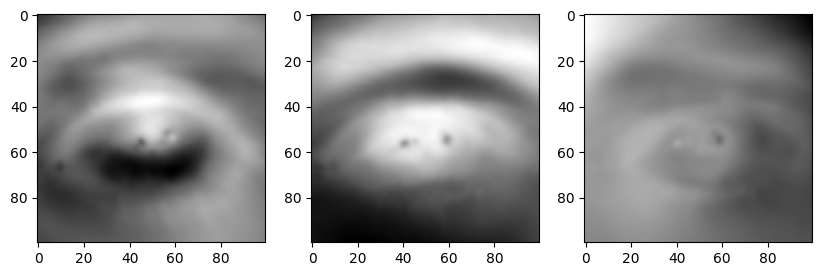

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.imshow(c1.reshape(100,100), cmap="gray")
ax2.imshow(c2.reshape(100,100), cmap="gray")
ax3.imshow(c3.reshape(100,100), cmap="gray")
plt.show()

# PCA presentation

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
X2D = pca.fit_transform(X_flattened)

print(X_flattened.shape)
print(X2D.shape)

(3200, 10000)
(3200, 40)


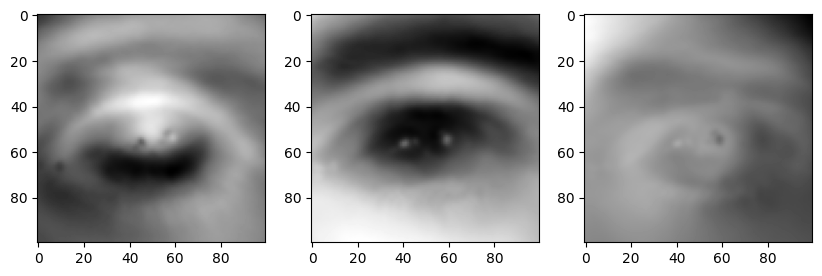

In [11]:
pc1 = pca.components_[0].reshape(100, 100)
pc2 = pca.components_[1].reshape(100, 100)
pc3 = pca.components_[2].reshape(100, 100)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.imshow(pc1, cmap="gray")
ax2.imshow(pc2, cmap="gray")
ax3.imshow(pc3, cmap="gray")
plt.show()

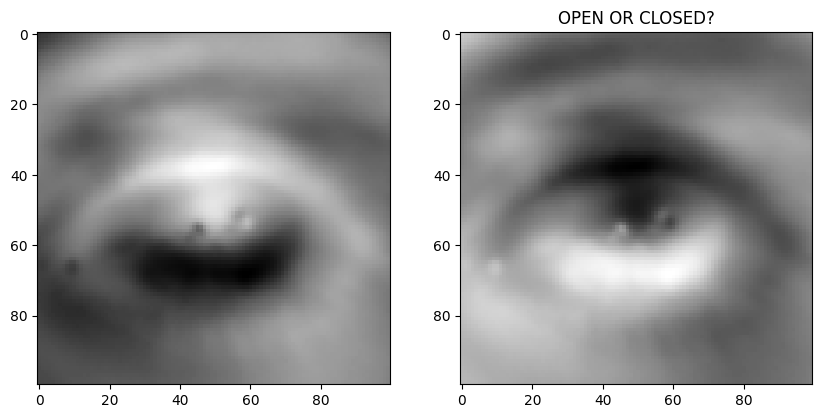

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
plt.title("OPEN OR CLOSED?")
ax1.imshow(pc1, cmap="gray")
ax2.imshow(-pc1, cmap="gray")
plt.show()

In [13]:
# how many points of variation it translates
print(pca.explained_variance_ratio_)
explained_variance = sum(pca.explained_variance_ratio_)
print("lost", (1.0 - explained_variance))


[5.75303723e-01 1.34808662e-01 1.00901878e-01 2.97540581e-02
 2.45346347e-02 2.09965006e-02 1.19083934e-02 1.07563794e-02
 9.39084242e-03 6.38822071e-03 5.43506625e-03 4.81662657e-03
 4.60455010e-03 4.05986998e-03 3.25098785e-03 3.11580167e-03
 2.51779968e-03 2.42131351e-03 2.13348759e-03 1.95561750e-03
 1.70351785e-03 1.57680568e-03 1.52350824e-03 1.34756041e-03
 1.26033265e-03 1.14885879e-03 1.12285625e-03 1.06353243e-03
 1.00973163e-03 9.38339811e-04 8.27737717e-04 8.17072871e-04
 7.61346234e-04 7.01212661e-04 6.81952583e-04 6.62880565e-04
 6.54927936e-04 6.00413355e-04 5.82592811e-04 5.32901788e-04]
lost 0.02142750430009266


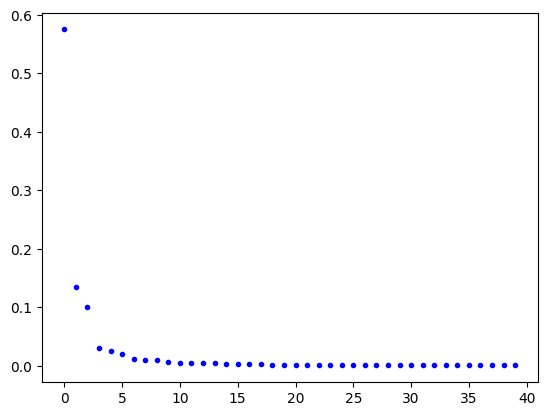

In [14]:
plt.plot(pca.explained_variance_ratio_, '.b')
plt.show()

15


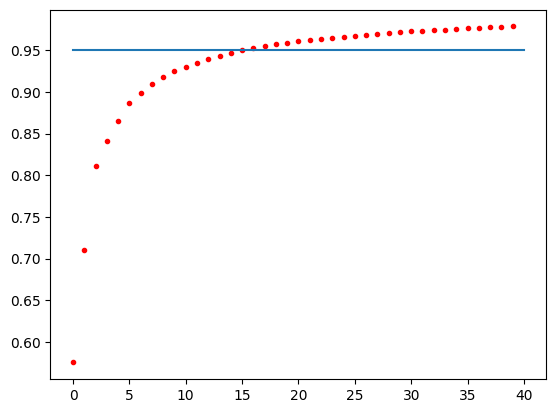

In [15]:
plt.plot(np.cumsum(pca.explained_variance_ratio_),'.r')
a = np.linspace(0, 40, 100) 
b = np.full_like(a, 0.95) 
plt.plot(a, b)

for i in range(len(np.cumsum(pca.explained_variance_ratio_))):
    if np.cumsum(pca.explained_variance_ratio_)[i] >= 0.95:
        break
print(i)
        
plt.show()

# Real PCA

In [16]:
pca = PCA(n_components=0.95)
X_train_flattened = pca.fit_transform(X_flattened)

In [17]:
X_test_flattened = X_test.reshape(800, -1)

In [18]:
X_test_flattened = pca.transform(X_test_flattened) # NOT FIT TRANSFORM

In [19]:
print(X_test_flattened.shape)
print(X_train_flattened.shape)

(800, 16)
(3200, 16)


# Standarization

In [21]:
from sklearn.preprocessing import StandardScaler

# mean = 0
# standard deviation = 1

scaler = StandardScaler()
X_train_flattened = scaler.fit_transform(X_train_flattened)
X_test_flattened = scaler.transform(X_test_flattened) # NOT FIT TRANSFORM
print(np.std(X_train_flattened))
print(abs(round(np.mean(X_train_flattened), 17)))


1.0
0.0


# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=1, random_state=42)


In [31]:
rnd_clf.fit(X_train.reshape(3200, -1), y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=1,
                       random_state=42)

## for curiosity

In [32]:
rnd_clf_for_cross_val = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=1, random_state=42)

In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rnd_clf_for_cross_val, X_train.reshape(3200, -1), y_train, cv=5)

In [37]:
print(scores)
print(scores.mean())
print(scores.std())

[0.9875    0.9921875 0.9921875 0.9890625 0.9875   ]
0.9896874999999999
0.0021194781197266307


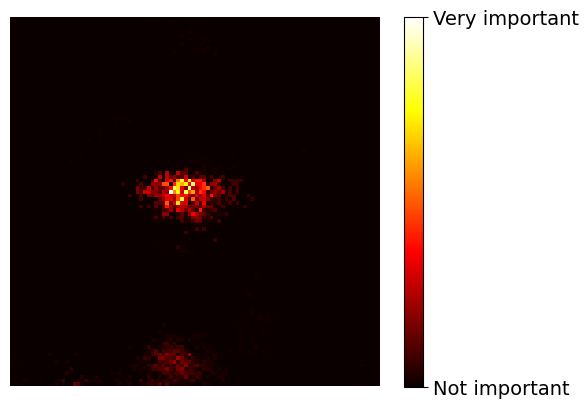

In [33]:
heatmap_image = rnd_clf.feature_importances_.reshape(100, 100)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

## end of for curiosity

In [38]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=1, random_state=42)


In [39]:
scores = cross_val_score(rnd_clf_for_cross_val, X_train_flattened, y_train, cv=5)

In [40]:
print(scores)
print(scores.mean())
print(scores.std())

[0.98125   0.984375  0.984375  0.975     0.9796875]
0.9809375000000001
0.0034798527267687674


# Hiperparameter tuning

In [73]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


In [71]:
'''
param_distr = {"n_estimators": randint(low=200, high=700), 'max_leaf_nodes': randint(low=8, high=24)}
rnd_clf = RandomForestClassifier(random_state=42, n_jobs=1)

rnd_search = RandomizedSearchCV(rnd_clf, param_distr, n_iter=10, cv=5, random_state=42, scoring='f1')
rnd_search.fit(X_train_flattened, y_train)
'''


SyntaxError: incomplete input (1073682558.py, line 3)

In [59]:
'''
cv_res = rnd_search.cv_results_

for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(mean_score, params)
'''

0.9782357140150474 {'max_leaf_nodes': 14, 'n_estimators': 635}
0.9874518749546365 {'max_leaf_nodes': 20, 'n_estimators': 470}
0.9846154442208285 {'max_leaf_nodes': 18, 'n_estimators': 271}
0.9874641017922207 {'max_leaf_nodes': 20, 'n_estimators': 220}
0.9794999779783964 {'max_leaf_nodes': 14, 'n_estimators': 321}
0.9686692440739517 {'max_leaf_nodes': 10, 'n_estimators': 414}
0.9849231678190687 {'max_leaf_nodes': 18, 'n_estimators': 658}
0.9795246075273123 {'max_leaf_nodes': 15, 'n_estimators': 572}
0.9702452758452095 {'max_leaf_nodes': 11, 'n_estimators': 559}
0.9798178728081902 {'max_leaf_nodes': 15, 'n_estimators': 330}


In [ ]:
#0.9874641017922207 {'max_leaf_nodes': 20, 'n_estimators': 220}

In [61]:
'''
param_grid = [{"n_estimators": [210, 220, 230], "max_leaf_nodes": [18, 20, 22]}]
rnd_clf = RandomForestClassifier(random_state=42, n_jobs=1)

grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_flattened, y_train)
'''

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1, random_state=42),
             param_grid=[{'max_leaf_nodes': [18, 20, 22],
                          'n_estimators': [210, 220, 230]}],
             scoring='f1')

In [65]:
'''
cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(mean_score, params)'''

0.9846213205875 {'max_leaf_nodes': 18, 'n_estimators': 210}
0.9846222745194193 {'max_leaf_nodes': 18, 'n_estimators': 220}
0.9849273974662316 {'max_leaf_nodes': 18, 'n_estimators': 230}
0.9874641017922207 {'max_leaf_nodes': 20, 'n_estimators': 210}
0.9874641017922207 {'max_leaf_nodes': 20, 'n_estimators': 220}
0.9874531815187233 {'max_leaf_nodes': 20, 'n_estimators': 230}
0.9902957288809666 {'max_leaf_nodes': 22, 'n_estimators': 210}
0.9902957288809666 {'max_leaf_nodes': 22, 'n_estimators': 220}
0.9902957288809666 {'max_leaf_nodes': 22, 'n_estimators': 230}


In [66]:
'''param_grid = [{"n_estimators": [230, 280, 350], "max_leaf_nodes": [24, 30, 36]}]
rnd_clf = RandomForestClassifier(random_state=42, n_jobs=1)

grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_flattened, y_train)'''

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1, random_state=42),
             param_grid=[{'max_leaf_nodes': [24, 30, 36],
                          'n_estimators': [230, 280, 350]}],
             scoring='f1')

In [68]:
'''cv_res = grid_search.cv_results_

for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(mean_score, params)'''

0.9909256097311052 {'max_leaf_nodes': 24, 'n_estimators': 230}
0.9909256097311052 {'max_leaf_nodes': 24, 'n_estimators': 280}
0.9906146637775114 {'max_leaf_nodes': 24, 'n_estimators': 350}
0.9918744736617645 {'max_leaf_nodes': 30, 'n_estimators': 230}
0.9918744736617645 {'max_leaf_nodes': 30, 'n_estimators': 280}
0.9921914074018788 {'max_leaf_nodes': 30, 'n_estimators': 350}
0.9937458635230053 {'max_leaf_nodes': 36, 'n_estimators': 230}
0.9934299171154148 {'max_leaf_nodes': 36, 'n_estimators': 280}
0.9940627972631196 {'max_leaf_nodes': 36, 'n_estimators': 350}


In [69]:
param_grid = [{"n_estimators": [600, 700, 800], "max_leaf_nodes": [50, 80, 100]}]
rnd_clf = RandomForestClassifier(random_state=42, n_jobs=1)

grid_search = GridSearchCV(rnd_clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_flattened, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1, random_state=42),
             param_grid=[{'max_leaf_nodes': [50, 80, 100],
                          'n_estimators': [600, 700, 800]}],
             scoring='f1')

In [70]:
cv_res = grid_search.cv_results_

for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(mean_score, params)

0.9953158152348383 {'max_leaf_nodes': 50, 'n_estimators': 600}
0.9949998750174203 {'max_leaf_nodes': 50, 'n_estimators': 700}
0.9953158152348383 {'max_leaf_nodes': 50, 'n_estimators': 800}
0.9965648737517092 {'max_leaf_nodes': 80, 'n_estimators': 600}
0.9965648737517092 {'max_leaf_nodes': 80, 'n_estimators': 700}
0.9959437602602023 {'max_leaf_nodes': 80, 'n_estimators': 800}
0.9965648737517092 {'max_leaf_nodes': 100, 'n_estimators': 600}
0.9965648737517092 {'max_leaf_nodes': 100, 'n_estimators': 700}
0.9959437602602023 {'max_leaf_nodes': 100, 'n_estimators': 800}


In [ ]:
# 0.9965648737517092 {'max_leaf_nodes': 80, 'n_estimators': 600} 

In [74]:
grid_search.best_estimator_.feature_importances_

array([0.14393233, 0.22456522, 0.0512711 , 0.03660927, 0.19016278,
       0.05704897, 0.01707664, 0.02645912, 0.03696457, 0.02917972,
       0.01645564, 0.02116557, 0.09049582, 0.02474217, 0.01414972,
       0.01972136])